![Funcional Health Tech](logo.png "Logo")

**COVID19 - Análise do Surto Brasileiro**

# Análise Exploratória com Inferência de Efeito Causal a partir de SRAGs

Neste *notebook* analisamos os dados reportados de casos de Síntrome Respiratória Aguda Grave (SRAG), sob a hipótese de que desse número se possa estimar uma boa aproximação do número real da incidência de COVID-19, já que supõe-se que a epidemia esteja subnotificada. A inferência de efeito causal é feita de modo rudimentar, empregando-se a versão Python da biblioteca [CausalImpact](https://github.com/dafiti/causalimpact).

Os dados analisados foram extraídos do sistema [Info Gripe da Fiocruz](http://info.gripe.fiocruz.br/), tais como disponibilizados oficialmente no [repositório da Fiocruz](https://gitlab.procc.fiocruz.br/mave/repo/-/tree/master/Dados/InfoGripe). 

Obs.: anteriormente havíamos empregado um [*scrapper* não-oficial](https://github.com/belisards/srag_brasil/) para obter esses dados, mas isso deixou de ser necessário.

**ADVERTÊNCIA:** os modelos e números aqui apresentados não são afirmações formais sobre o progresso da doença, mas apenas exercícios que demonstram técnicas de modelagem e cenários de aplicação.

## Preliminares
Bibliotecas, configurações e parâmetros.

In [26]:
import os
import math
from causalimpact import CausalImpact
import pandas as pd
pd.set_option("display.max_columns", 100)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [27]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

Se necessário, ajuste o diretório de trabalho para ser o que contém este *notebook*.

In [28]:
#print(os.getcwd())
#os.chdir('covid19-analytics/notebooks')
#os.getcwd()

Tomemos o cuidado de determinar o dia em que as semanas epidemiológicas terminam, que [parece ser aos sábados](https://portalsinan.saude.gov.br/calendario-epidemiologico).

In [29]:
week_offset = pd.offsets.Week(weekday=5)

## Leitura e Preparação



In [30]:
df_covid = pd.read_csv(f'../data/ourworldindata.org/coronavirus-source-data/full_data.csv', parse_dates=['date'])
df_covid_target = df_covid[df_covid['location'] == 'Brazil']
df_covid_target = df_covid_target.set_index('date').resample(week_offset).sum()
df_covid_target#.tail(15)

,new_cases,new_deaths,total_cases,total_deaths
date,,,,
2020-01-04,0,0,0,0
2020-01-11,0,0,0,0
2020-01-18,0,0,0,0
2020-01-25,0,0,0,0
2020-02-01,0,0,0,0
2020-02-08,0,0,0,0
2020-02-15,0,0,0,0
2020-02-22,0,0,0,0
2020-02-29,1,0,4,0


In [31]:
df_srag_raw = pd.read_csv("../data/large/fiocruz/infogripe/dados_semanais_faixa_etaria_sexo_virus_sem_filtro_sintomas.csv", decimal=",", sep=';', parse_dates=[0])
#df_srag_raw = pd.read_csv("../data/large/fiocruz/infogripe/dados_semanais_faixa_etaria_sexo_virus.csv", decimal=",", sep=';', parse_dates=[0])

df_srag_raw.head()

,data de publicação,UF,Unidade da Federação,Tipo,dado,escala,sexo,Ano epidemiológico,Semana epidemiológica,Ano e semana epidemiológica,Situação do dado,Total reportado até a última atualização,Idade desconhecida,< 2 anos,0-4 anos,10-19 anos,2-4 anos,20-29 anos,30-39 anos,40-49 anos,5-9 anos,50-59 anos,60+ anos,Testes positivos,Testes negativos,Casos aguardando resultado,Casos sem informação laboratorial,Casos sem teste laboratorial,Influenza A,Influenza B,SARS-CoV-2,Vírus sincicial respiratório (VSR),Parainfluenza 1,Parainfluenza 2,Parainfluenza 3,Adenovirus
0,2020-05-26,11,Rondônia,Estado,srag,incidência,F,2009,1,2009W01,Dado estável. Sujeito a pequenas alterações.,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-05-26,11,Rondônia,Estado,srag,incidência,M,2009,1,2009W01,Dado estável. Sujeito a pequenas alterações.,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-05-26,11,Rondônia,Estado,srag,incidência,Total,2009,1,2009W01,Dado estável. Sujeito a pequenas alterações.,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-05-26,11,Rondônia,Estado,srag,incidência,F,2009,2,2009W02,Dado estável. Sujeito a pequenas alterações.,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-05-26,11,Rondônia,Estado,srag,incidência,M,2009,2,2009W02,Dado estável. Sujeito a pequenas alterações.,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
print(df_srag_raw['Tipo'].unique())
print(df_srag_raw['dado'].unique())
print(df_srag_raw['escala'].unique())
print(df_srag_raw['sexo'].unique())

['Estado' 'País' 'Região' 'Regional']
['srag' 'sragflu' 'obitoflu' 'sragcovid' 'obitocovid' 'obito']
['incidência' 'casos']
['F' 'M' 'Total' 'I']


In [33]:
df_srag_raw = \
    df_srag_raw[(df_srag_raw['Tipo'] == 'País') &\
                (df_srag_raw['dado'] == 'srag') &\
                (df_srag_raw['escala'] == 'casos') &\
                (df_srag_raw['sexo'] == 'Total')]
df_srag_raw.tail()

,data de publicação,UF,Unidade da Federação,Tipo,dado,escala,sexo,Ano epidemiológico,Semana epidemiológica,Ano e semana epidemiológica,Situação do dado,Total reportado até a última atualização,Idade desconhecida,< 2 anos,0-4 anos,10-19 anos,2-4 anos,20-29 anos,30-39 anos,40-49 anos,5-9 anos,50-59 anos,60+ anos,Testes positivos,Testes negativos,Casos aguardando resultado,Casos sem informação laboratorial,Casos sem teste laboratorial,Influenza A,Influenza B,SARS-CoV-2,Vírus sincicial respiratório (VSR),Parainfluenza 1,Parainfluenza 2,Parainfluenza 3,Adenovirus
132445,2020-05-26,0,Brasil,País,srag,casos,Total,2020,17,2020W17,Dados incompletos. Sujeito a grandes alterações.,22292.0,0.0,556.0,NaN,345.0,179.0,1087.0,2346.0,3103.0,141.0,3851.0,10684.0,8717.0,6330.0,5159.0,1313.0,739.0,5.0,6.0,8581.0,19.0,0.0,0.0,0.0,5.0
132449,2020-05-26,0,Brasil,País,srag,casos,Total,2020,18,2020W18,Dados incompletos. Sujeito a grandes alterações.,23390.0,0.0,558.0,NaN,332.0,187.0,1029.0,2274.0,3157.0,139.0,4037.0,11677.0,8477.0,5706.0,6924.0,1465.0,788.0,2.0,1.0,8331.0,16.0,0.0,0.0,0.0,7.0
132453,2020-05-26,0,Brasil,País,srag,casos,Total,2020,19,2020W19,Dados incompletos. Sujeito a grandes alterações.,20847.0,0.0,486.0,NaN,334.0,167.0,954.0,2007.0,2758.0,182.0,3400.0,10559.0,6239.0,4601.0,8065.0,1333.0,588.0,3.0,1.0,6102.0,21.0,1.0,0.0,0.0,6.0
132457,2020-05-26,0,Brasil,País,srag,casos,Total,2020,20,2020W20,Dados incompletos. Sujeito a grandes alterações.,16428.0,0.0,459.0,NaN,327.0,172.0,738.0,1501.0,1996.0,173.0,2487.0,8575.0,3285.0,2964.0,8677.0,1056.0,433.0,4.0,0.0,3155.0,11.0,0.0,0.0,0.0,3.0
132461,2020-05-26,0,Brasil,País,srag,casos,Total,2020,21,2020W21,Dados incompletos. Sujeito a grandes alterações.,5185.0,0.0,158.0,NaN,127.0,67.0,249.0,414.0,532.0,65.0,672.0,2901.0,489.0,488.0,3696.0,364.0,147.0,0.0,1.0,469.0,0.0,0.0,0.0,0.0,2.0


In [34]:
try:
    # we get the last trustworthy data point
    min_trustworthy_week = df_srag_raw[df_srag_raw['Situação do dado'].str.contains('Dados incompletos')]['Semana epidemiológica'].min() - 1
except Exception:
    min_trustworthy_week = None

min_trustworthy_week

16

In [35]:
df_srag_raw['year'] = df_srag_raw.loc[:, 'Ano epidemiológico']
df_srag_raw['epidemiological_week'] = df_srag_raw.loc[:, 'Semana epidemiológica']
df_srag_raw['total_cases'] = df_srag_raw.loc[:, 'Total reportado até a última atualização']

df_srag_raw = df_srag_raw[['year', 'epidemiological_week', 'total_cases']]

df_srag_raw.head()

,year,epidemiological_week,total_cases
130089,2009,1,0.0
130093,2009,2,0.0
130097,2009,3,0.0
130101,2009,4,0.0
130105,2009,5,0.0


In [36]:
## https://github.com/belisards/srag_brasil/
#df_srag_raw = pd.read_csv(f'../data/srag_brasil/casos_br.csv')\
#                    .rename(columns={'ano': 'year', 'epiweek': 'epidemiological_week', 'casos': 'total_cases'})
##
#df_srag_raw.head()

## Comparação Das Semanas Epidemiológicas

Como foi a incidência de SRAG ao longo dos anos, quando comparamos as mesmas semanas?

In [37]:
cols = {}
timeline = []
years = df_srag_raw['year'].unique()
for year in years:
    cols[year] = df_srag_raw[df_srag_raw['year'] == year].sort_values('epidemiological_week')['total_cases'].reset_index(drop=True)
    timeline = timeline + list(cols[year].values)

df_srag_timeline = pd.DataFrame(timeline) 
df_srag = pd.DataFrame(cols)
df_srag.head()

,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,0.0,223.0,39.0,88.0,99.0,115.0,146.0,128.0,245.0,264.0,316.0,373.0
1,0.0,178.0,43.0,59.0,101.0,193.0,145.0,114.0,222.0,232.0,289.0,401.0
2,0.0,180.0,36.0,70.0,104.0,171.0,140.0,137.0,204.0,238.0,274.0,410.0
3,0.0,160.0,26.0,70.0,121.0,150.0,121.0,160.0,230.0,209.0,277.0,379.0
4,0.0,191.0,38.0,63.0,119.0,162.0,135.0,168.0,277.0,214.0,326.0,399.0


Text(0.5, 1.0, 'SRAG por semana epidemiológica por ano')

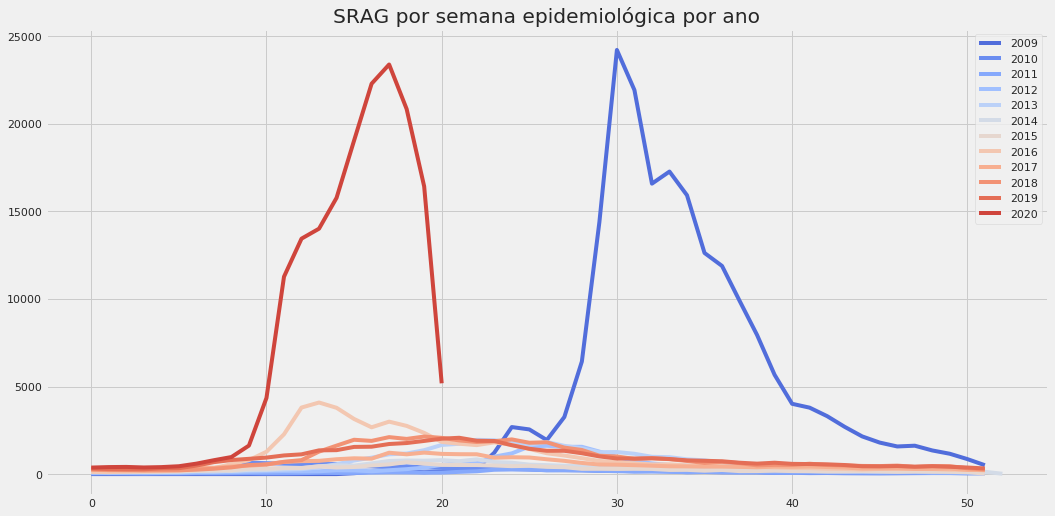

In [38]:
palette = sns.color_palette("coolwarm", len(df_srag.columns))
ax = sns.lineplot(data=df_srag, palette=palette, dashes=False)
ax.set_title('SRAG por semana epidemiológica por ano')

Uma visão alternativa para esses mesmos dados, que enfatiza a proporção em cada ano.

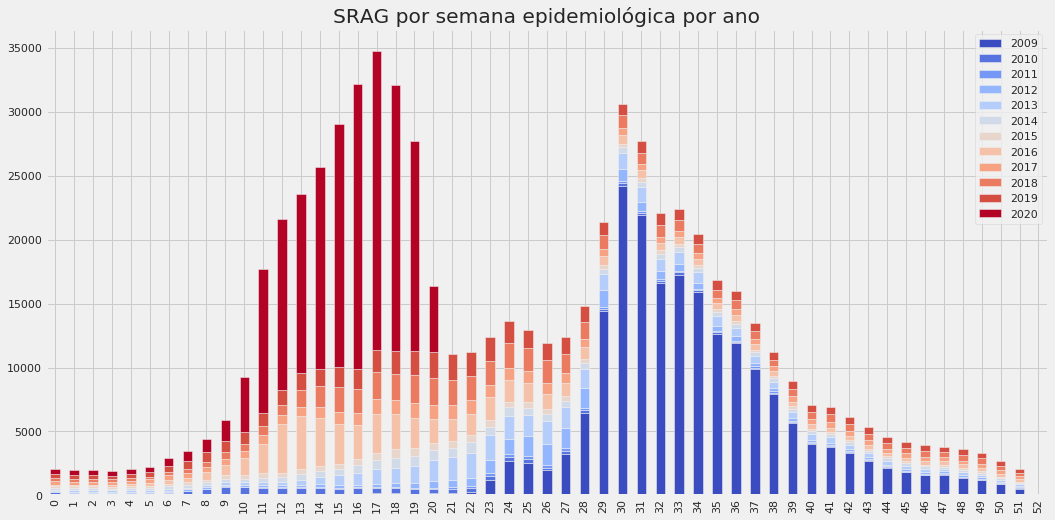

In [39]:
df_srag.plot(kind='bar', stacked=True, colormap='coolwarm', title='SRAG por semana epidemiológica por ano')

Vemos que em 2009 houve um pico bastante anormal, certamente por conta da epidemia de H1N1.

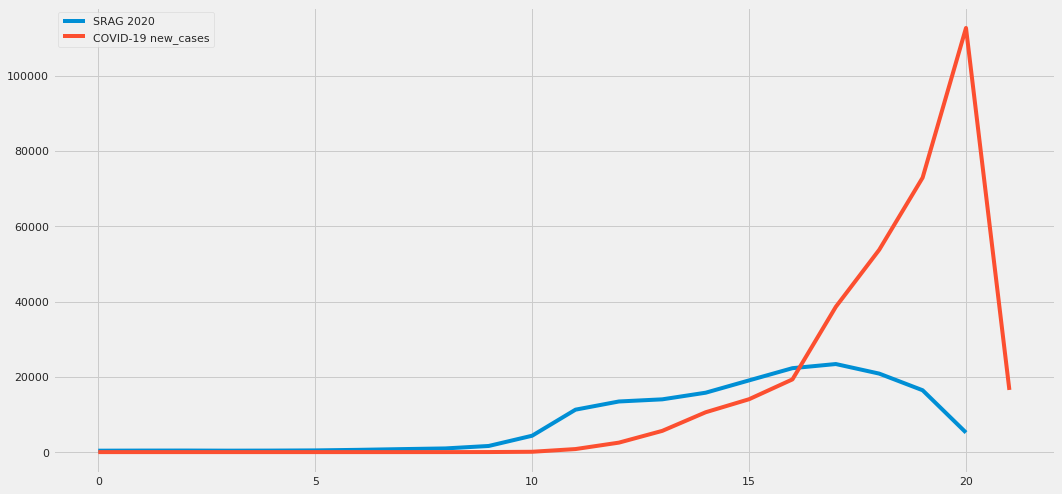

In [40]:
df_comparison =pd.concat([df_srag[2020].rename('SRAG 2020'), 
                          df_covid_target['new_cases'].rename('COVID-19 new_cases').reset_index(drop=True)], axis=1)

ax = sns.lineplot(data=df_comparison, dashes=False)

Qual a magnitude da diferença ao longo do tempo?

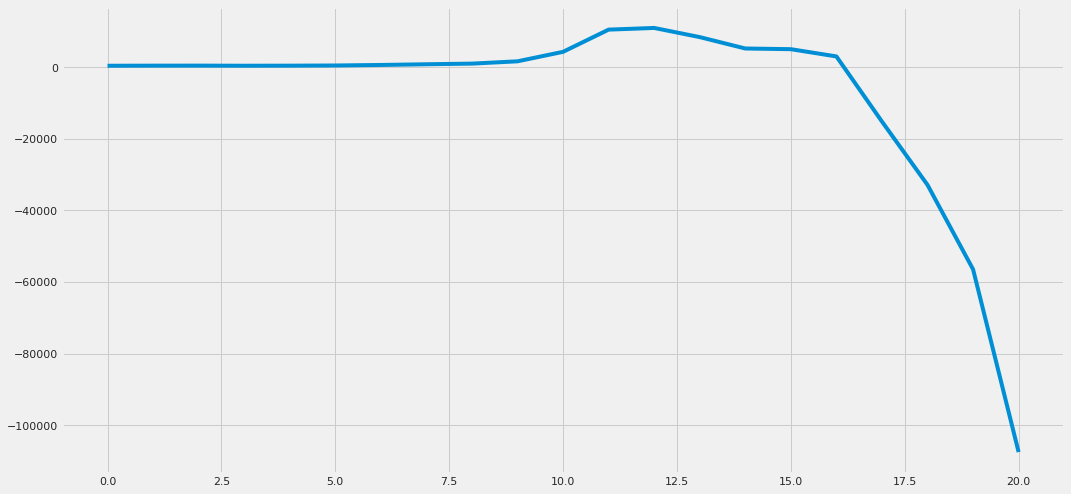

In [41]:
ax = sns.lineplot(data=(df_comparison.iloc[:, 0] - df_comparison.iloc[:, 1]), dashes=False)

## Estimativa de Efeito Causal: CausalImpact

Para estimar o efeito causal supostamente introduzido pela COVID-19, usaremos [a biblioteca CausalImpact](https://github.com/dafiti/causalimpact), a qual exige que os dados sejam dispostos de forma linear no tempo.

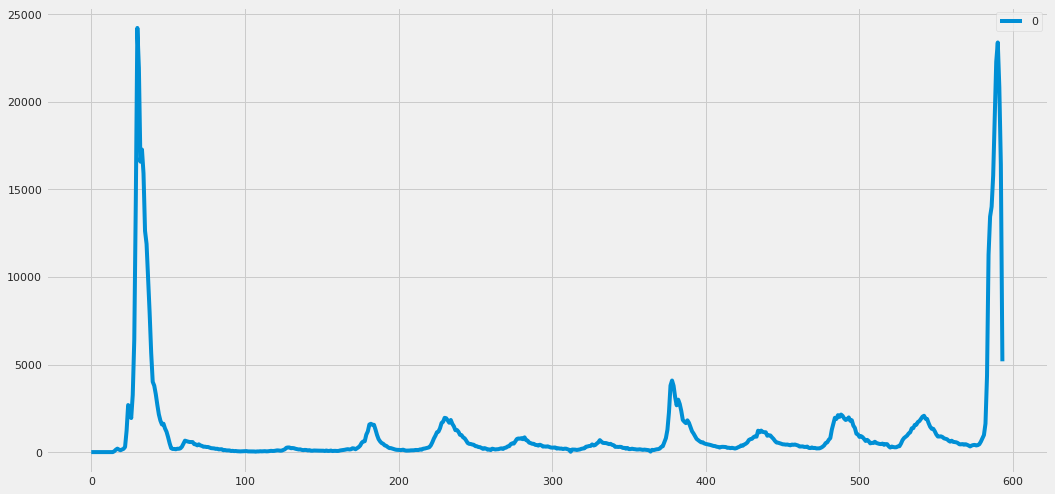

In [42]:
ax = sns.lineplot(data=df_srag_timeline, dashes=False)

Coloquemos a suposta intervenção causal na primeira semana de 2020.

In [43]:
years

array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020])

Intervention week: 572
Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    2728.23            35467.0
Prediction (s.d.)         822.28 (604.23)    10689.6 (7854.96)
95% CI                    [-304.03, 2064.5]  [-3952.33, 26838.56]

Absolute effect (s.d.)    1905.95 (604.23)   24777.4 (7854.96)
95% CI                    [663.73, 3032.26]  [8628.44, 39419.33]

Relative effect (s.d.)    231.79% (73.48%)   231.79% (73.48%)
95% CI                    [80.72%, 368.76%]  [80.72%, 368.76%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.9%

For more details run the command: print(impact.summary('report'))


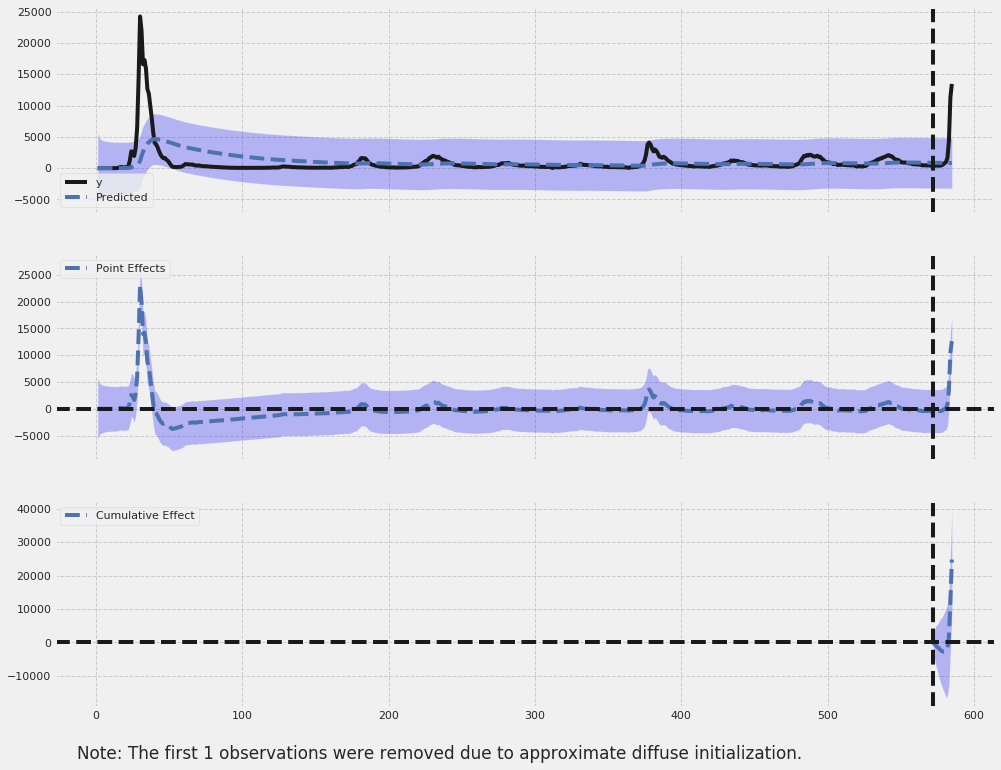

In [44]:
intervention_week = (len(years) - 1) * 52  # all years, except the last one
print("Intervention week:", intervention_week)
pre_period = [0, intervention_week]
post_period = [intervention_week+1, 585]

ci = CausalImpact(df_srag_timeline, pre_period, post_period)
print(ci.summary())
#print(ci.summary(output='report'))
ci.plot()

Podemos então isolar o efeito estimado.

In [45]:
df_causal_effect_1 = ci.inferences.dropna()[['point_effects', 'point_effects_lower', 'point_effects_upper']]
df_causal_effect_1#.head()

,point_effects,point_effects_lower,point_effects_upper
573,-449.277255,-4480.216737,3581.662228
574,-421.277255,-4452.534962,3609.980453
575,-412.277255,-4443.853163,3619.298654
576,-443.277255,-4475.171338,3588.616829
577,-423.277255,-4455.489489,3608.934979
578,-373.277255,-4405.807614,3659.253105
579,-225.277255,-4258.125714,3807.571205
580,-29.277255,-4062.443789,4003.889280
581,151.722745,-3881.761839,4185.207330
582,805.722745,-3228.079863,4839.525354


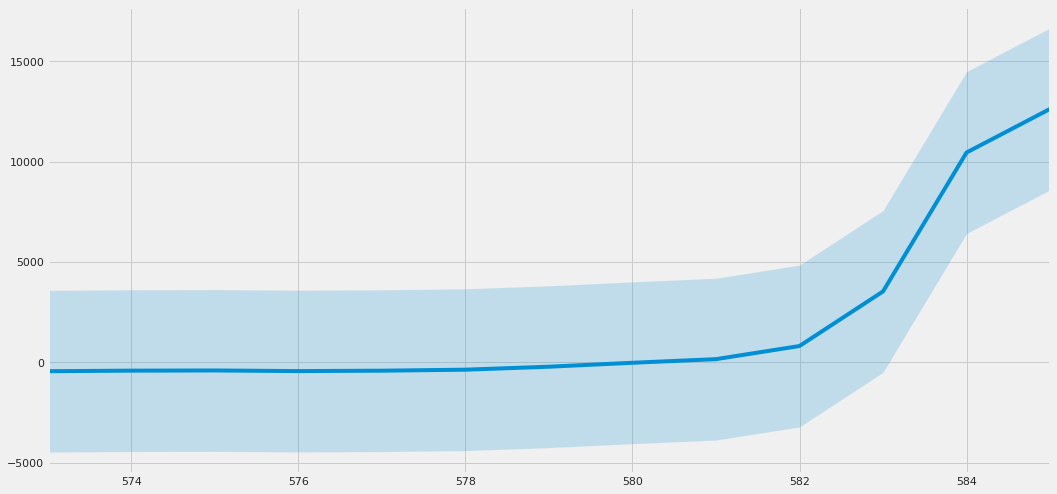

In [46]:
df_causal_effect_1['point_effects'].plot()
plt.fill_between(df_causal_effect_1.index, 
                 df_causal_effect_1[['point_effects_lower', 'point_effects_upper']].values[:, 0],
                df_causal_effect_1[['point_effects_lower', 'point_effects_upper']].values[:, 1],
                alpha=0.2)

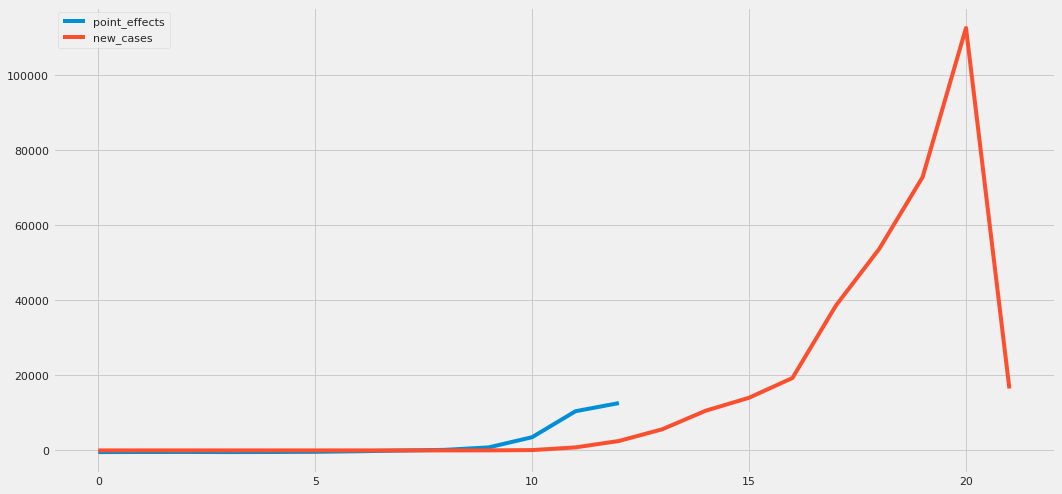

In [47]:
df_comparison_2 =pd.concat([df_causal_effect_1['point_effects'].reset_index(drop=True), 
                            df_covid_target['new_cases'].reset_index(drop=True)], axis=1)

ax = sns.lineplot(data=df_comparison_2, dashes=False)

E calcular a razão entre SRAGs e COVID-19 oficial.

8     151.722745
9      67.143562
10     41.490856
11     12.963676
12      5.022572
dtype: float64

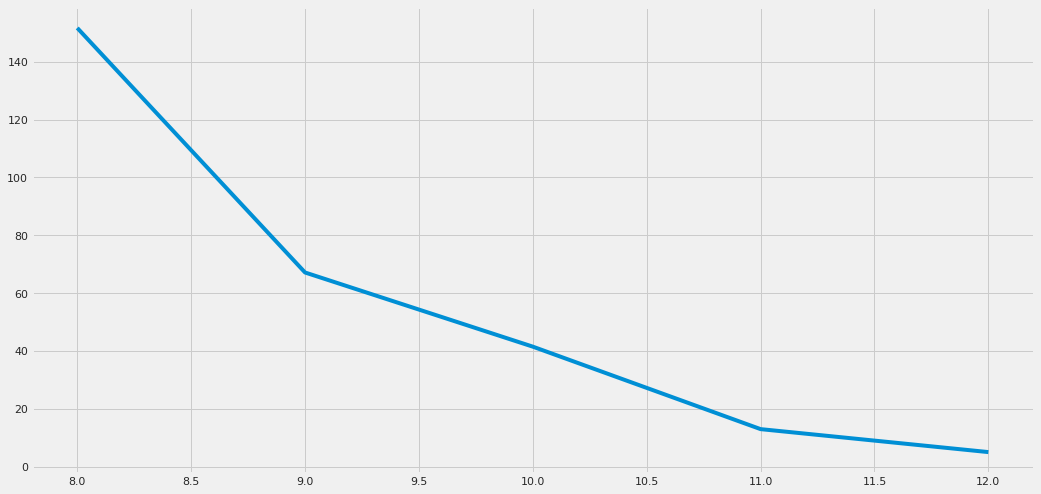

In [48]:
s_a = df_causal_effect_1['point_effects'].reset_index(drop=True)
s_b =  df_covid_target['new_cases'].reset_index(drop=True)
s_ratio_1 = (s_a/s_b)
s_ratio_1 = s_ratio_1[(s_ratio_1 != np.inf) & (s_ratio_1 != -np.inf)].dropna()
ax = sns.lineplot(data=s_ratio_1, 
                  dashes=False)
s_ratio_1

## Estimativa de Efeito Causal: Manual

Façamos agora uma análise manual, supondo-se que as mesmas semanas epidemiológicas em anos diferentes tendem a ter comportamentos semelhantes, salvo em casos excepcionais. Assim, iremos atribuir a diferença (média, mínima, máxima) observada nas semanas do ano corrente a algum fator novo, nomeadamente à COVID-19.

In [49]:
s_srag_cur = df_srag.iloc[:, -1]
df_srag_past = df_srag.iloc[:, :-1]

In [50]:
s_effect_lower = (s_srag_cur - df_srag_past.max(axis=1)).rename('causal_effect_lower')
s_effect_upper = (s_srag_cur - df_srag_past.min(axis=1)).rename('causal_effect_upper')
s_effect_mean = (s_srag_cur - df_srag_past.mean(axis=1)).rename('causal_effect_mean')


df_causal_effect_2 = pd.concat([s_effect_mean, s_effect_lower, s_effect_upper], axis=1) 
df_causal_effect_2.head(15)

,causal_effect_mean,causal_effect_lower,causal_effect_upper
0,221.818182,57.0,373.0
1,257.727273,112.0,401.0
2,268.727273,136.0,410.0
3,240.454545,102.0,379.0
4,245.090909,73.0,399.0
5,285.454545,113.0,449.0
6,387.454545,112.0,597.0
7,547.454545,111.0,793.0
8,664.000000,172.0,974.0
9,1241.454545,756.0,1628.0


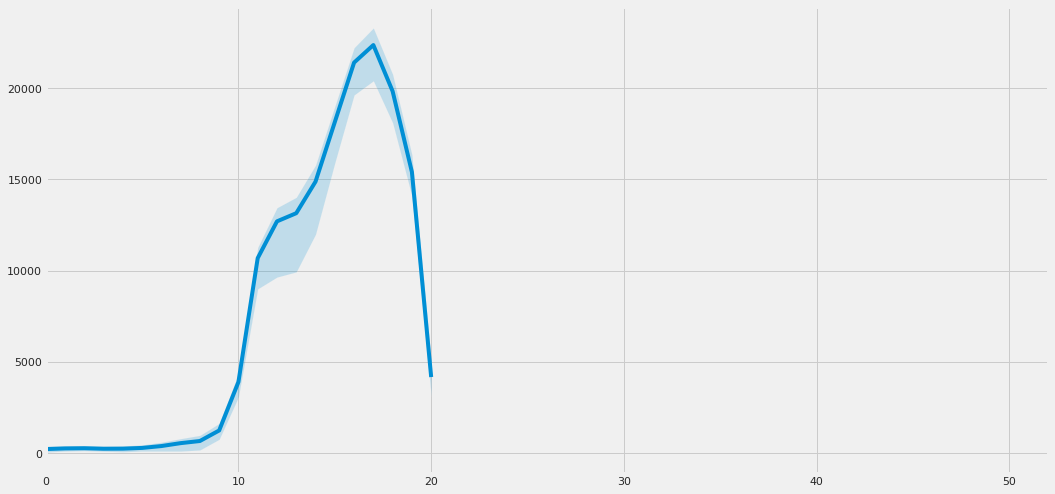

In [51]:
df_causal_effect_2['causal_effect_mean'].plot()
plt.fill_between(df_causal_effect_2.index, 
                 df_causal_effect_2[['causal_effect_lower', 'causal_effect_upper']].values[:, 0],
                 df_causal_effect_2[['causal_effect_lower', 'causal_effect_upper']].values[:, 1],
                 alpha=0.2)

8     664.000000
9     103.454545
10     45.881283
11     13.255132
12      5.052599
13      2.330990
14      1.405612
15      1.291467
16      1.107798
17      0.579249
18      0.368879
19      0.211295
20      0.036997
dtype: float64

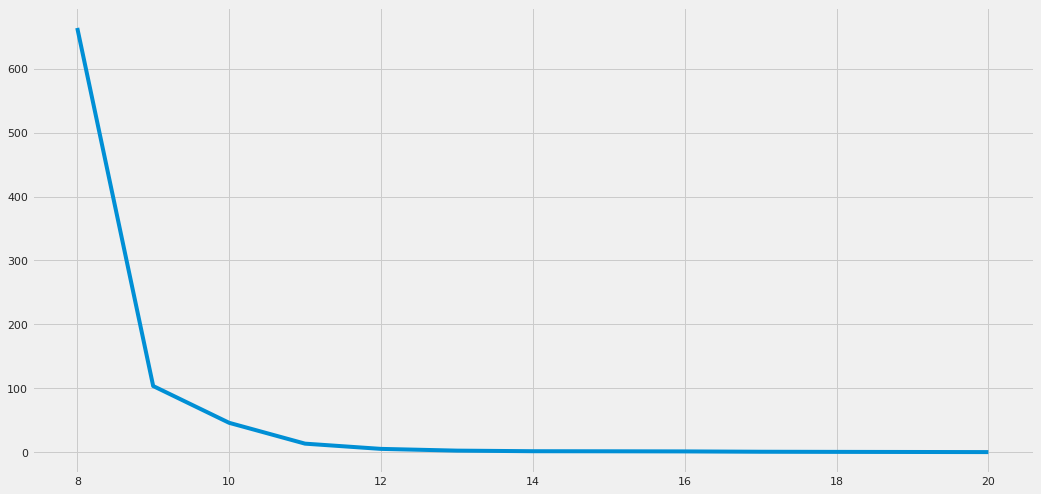

In [52]:
s_a = df_causal_effect_2['causal_effect_mean'].reset_index(drop=True)
s_b =  df_covid_target['new_cases'].reset_index(drop=True)

s_ratio_2 = (s_a/s_b)

s_ratio_2 = s_ratio_2[(s_ratio_2 != np.inf) & (s_ratio_2 != -np.inf)].dropna()
ax = sns.lineplot(data=s_ratio_2, 
                  dashes=False)
s_ratio_2

Os resultados dessa última estimativa de efeito causal parecem mais confiáveis, então a tomaremos como base para a conclusão deste estudo.

In [53]:
s_ratio = s_ratio_2

## Conclusão

Nota-se grande discrepância entre casos usuais de SRAG e casos reportados. Atribuimos assim os casos adicionais à COVID-19. Alguns outros ajustes são necessários para obtermos multiplicadores de ajuste adequados:

  - Note-se ainda que os casos de SRAG reportados referem-se a hospitalizações, que são apenas uma parte dos casos totais esperados de COVID-19. Portanto, para se estimar os casos totais de COVID-19, devemos ainda ajustar a estimativa de hospitalizados de acordo com a probabilidade de ser hospitalizado dado que se tem COVID-19. 
  - Usamos apenas dados considerados já confiáveis. Isso tipicamente exige que desconsideremos algumas semanas mais recentes (variável `min_trustworthy_week`), cujos valores ainda estão sujeitos a grandes mudanças à lentidão com a qual a base de SRAG é atualizada.
  - Supomos que o multiplicador de ajuste nunca pode ser menor do que 1.0, posto que queremos contemplar ao menos os casos reportados.

In [54]:
# Combination of hospitalization rates per age found in 
#
#    https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30243-7/fulltext
# with demographic data found in
# 
#    https://censo2010.ibge.gov.br/sinopse/index.php?dados=12
#
p_hospitalization = (0.037+0.04)*0.0 + (0.046+0.045)*0.000408 + (0.045+0.044)*0.0105 + (0.04+0.35)*0.0343 + (0.033+0.030)*0.0425 +\
                    (0.025+0.02)*0.0816 + (0.016+0.012)*0.118 + (0.009+0.006)*0.166 + (0.004+0.002+0.001)*0.184   
                     #0.034 #0.2
p_hospitalization

0.027780127999999998

8     23901.977701
9      3724.048552
10     1651.586466
11      477.144381
12      181.878183
13       83.908553
14       50.597736
15       46.488881
16       39.877366
17       39.877366
18       39.877366
19       39.877366
20       39.877366
Name: SRAG_adjustment_multiplier, dtype: float64

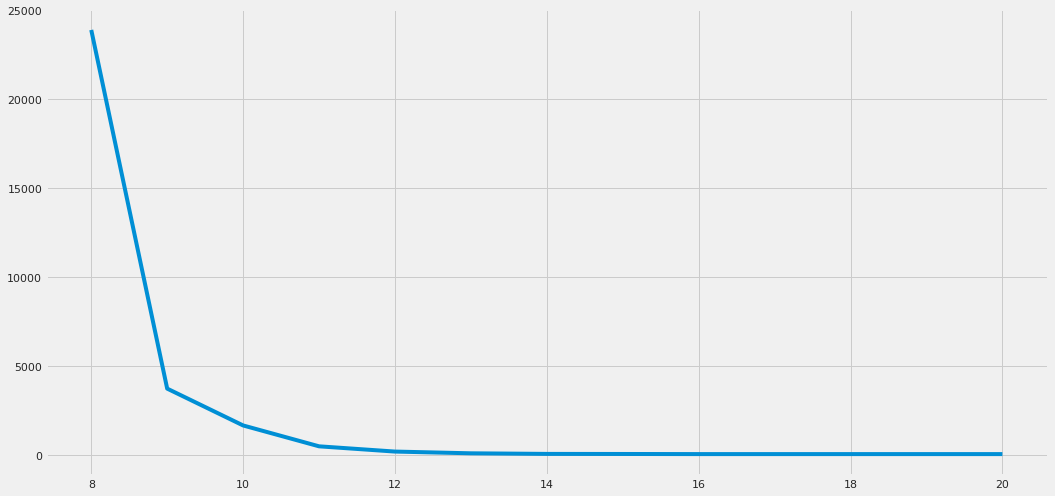

In [55]:
s_adjustment_multipler = s_ratio[s_ratio > 0] / p_hospitalization
s_adjustment_multipler = s_adjustment_multipler.rename('SRAG_adjustment_multiplier')

# we use only the estimates that are trustworthy
s_adjustment_multipler.loc[min_trustworthy_week+1:] = s_adjustment_multipler.loc[min_trustworthy_week]


# we assume that data can never be less than the original estimate
s_adjustment_multipler[s_adjustment_multipler < 1.0] = 1.0

ax = sns.lineplot(data=s_adjustment_multipler, 
                  dashes=False)


s_adjustment_multipler

Vemos assim que as diferenças estimadas são bastante expressivas, o que deve ter impacto na previsão da dinâmica epidemiológica.

Salvemos esses multiplicadores de ajuste para uso posterior. Por conveniência, vamos diarizar esses valores.

In [31]:
weeks = range(0, s_adjustment_multipler.index[-1])

In [32]:
df_daily_adjustment_multipler = \
    df_covid_target\
        .reset_index()\
        .merge(s_adjustment_multipler, left_index=True, right_index=True)\
        .set_index('date')\
        .resample('D')\
        .bfill()\
        [['SRAG_adjustment_multiplier']]

df_daily_adjustment_multipler

,SRAG_adjustment_multiplier
date,
2020-02-29,23973.971610
2020-03-01,3664.053628
2020-03-02,3664.053628
2020-03-03,3664.053628
2020-03-04,3664.053628
2020-03-05,3664.053628
2020-03-06,3664.053628
2020-03-07,3664.053628
2020-03-08,1632.105761


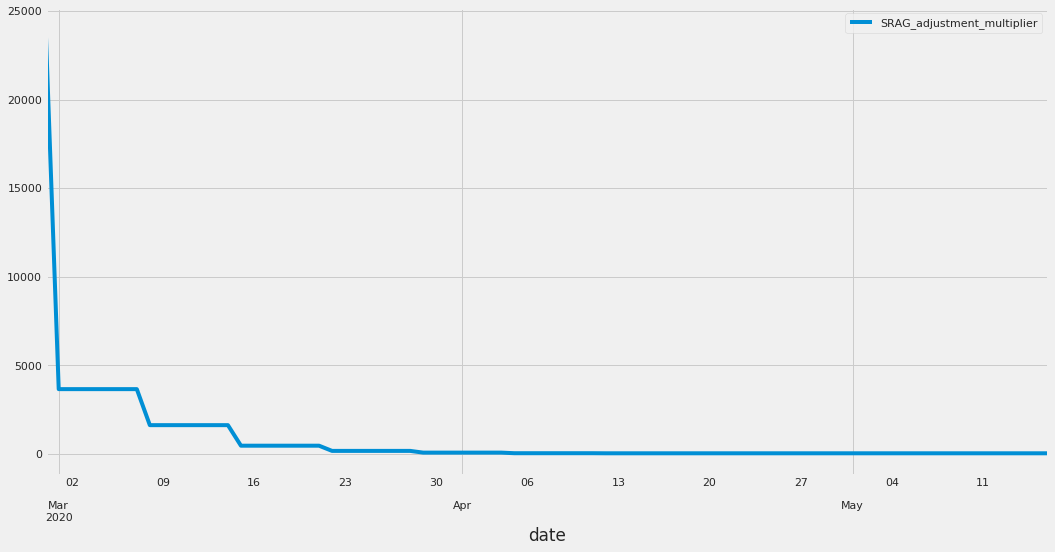

In [33]:
df_daily_adjustment_multipler.plot()

In [34]:
df_daily_adjustment_multipler.to_csv('../results/srag_adjustment_multipliers.brazil.csv')